In [1]:
!wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
!unzip -q img_align_celeba
!pip install torch
!pip install torchvision

--2018-11-01 18:28:51--  https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 74.125.124.113, 74.125.124.138, 74.125.124.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.16K  --.-KB/s    in 0s      

2018-11-01 18:28:52 (28.3 MB/s) - written to stdout [3238]

--2018-11-01 18:28:52--  https://docs.google.com/uc?export=download&confirm=dQG&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 173.194.192.102, 173.194.192.100, 173.194.192.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.192.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘img_align_celeba.zip’

img_align_celeba.zi     [ <=>                ]   3.18K  --.-KB/s   

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils, datasets
import torchvision.models as models
import os
from IPython import display


unloader = transforms.ToPILImage()  # reconvert into PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.001)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

class CelebDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    return img[0]
 
  def __len__(self):
    return len(self.dataset_folder)
  
#dataset = CelebDataset(root="./")
#dataset[200500]
#imshow(a)

Set up our generator class

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    #self.fully_connected = nn.Linear(100, 1024*4*4, bias=False)
    self.ngf= 128
    self.other_layers = nn.Sequential(       
     # nn.ConvTranspose2d(1024, 512, 5,1, bias=False),
      #nn.ReLU(),
      #nn.ConvTranspose2d(512, 256, 2, 2, bias=False),
      #nn.ReLU(),
      #nn.ConvTranspose2d(256, 128, 2,2, bias=False),
      #nn.ReLU(),
      #nn.ConvTranspose2d(128, 64, 2,2, bias=False),
      #nn.ReLU(),
      #nn.ConvTranspose2d(64,3, 2,2, bias=False),
 
      # input is Z, going into a convolution
      nn.ConvTranspose2d(     100, self.ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(self.ngf * 8),
      nn.ReLU(True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(self.ngf * 4),
      nn.ReLU(True),
      # state size. (self.ngf*4) x 8 x 8
      nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(self.ngf * 2),
      nn.ReLU(True),
      # state size. (self.ngf*2) x 16 x 16
      nn.ConvTranspose2d(self.ngf * 2,     self.ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(self.ngf),
      nn.ReLU(True),
       #state size. (self.ngf) x 32 x 32
      nn.ConvTranspose2d(    self.ngf,      3, 6, 4, 1, bias=False),
      #nn.Tanh()
      # state size. (nc) x 64 x 64
    )
  def forward(self, zvec):
    #print(zvec.size())
    #fc = self.fully_connected(zvec)
    #reshaped = fc.view(-1, 1024,4,4)
    #print(reshaped.size())
    final= self.other_layers(zvec.unsqueeze(2).unsqueeze(2))
    #mins = torch.min(final)
    #return((final - mins ) / (torch.max(final) - mins))
    return(final)

In [0]:
#gen = Generator();
#print(type(gen))
#image=gen(torch.from_numpy(np.random.normal(size=100)).float().unsqueeze(0))
#print(image.size())
#imshow(image)


Set up our discriminator class

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    ndf=128
    self.net = nn.Sequential(
        #nn.Conv2d(3, 8, 3,2,1, bias=False),
       # nn.LeakyReLU(.2),
        #nn.Conv2d(8, 16, 3,2,1, bias=False),
        #nn.LeakyReLU(.2),
        #nn.Conv2d(16, 32, 3,2,1, bias=False),
        #nn.LeakyReLU(.2),
        #nn.Conv2d(32, 64, 4,2,1, bias=False),
        #nn.LeakyReLU(.2),
        #nn.Conv2d(64, 1, 8, 1, bias=False)
         # input is (nc) x 64 x 64
        nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        #nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        #nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        #nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 8, 1, 0, bias=False),
        #nn.Sigmoid()
    )
   
  def forward(self, face):
    final = self.net(face)
    return(final)

In [0]:
#disc = Discriminator()
#print(type(disc))
#critic=disc(data[23].unsqueeze(0))
#print(critic.size())
#print(critic)

In [0]:
#a=torch.Tensor(5,3,128,128)
#a.size()
#torch.split(a, 1, dim=0)[0].size()

Now we will run the training loop on our generator and discriminator

Epoch 0


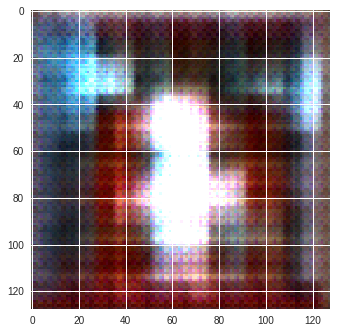

KeyboardInterrupt: ignored

In [17]:
beta1 = 0.5 # 0
beta2 = 0.9 # 0.9
lambd= 10
ncritic = 1 # 5
learning_rate = 0.0002 # 0.0001
batch_size = 200
epochs=range(4)

#initialize your generator and discriminator models
#discriminator = Discriminator().cuda()
#generator=Generator().cuda()

#initialize separate optimizer for both gen and disc
#d_optim =  optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(beta1, beta2))
#g_optim = optim.Adam(generator.parameters(), lr = learning_rate, betas=(beta1, beta2))
  
#initialize your dataset and dataloader
#data=CelebDataset(root="./")
#trainloader=DataLoader(data, batch_size=batch_size)
 
i = 0 
for e in epochs:
  for true_img in trainloader:
    inBatch=true_img.size()[0]
    i+=1
    true_img=true_img.cuda()
    #train discriminator#
    #because you want to be able to backprop through the params in discriminator 
    for p in discriminator.parameters():
      p.requires_grad = True
    #for g in generator.parameters():
    #  g.requires_grad=False
 
    for n in range(ncritic):
      d_optim.zero_grad()
      
      z=torch.from_numpy(np.random.normal(size=100*inBatch)).float().cuda().view(-1,100)
      fakeFaces = generator(z)
      eps = torch.from_numpy(np.random.uniform(size=inBatch)).float().cuda().view(inBatch,1,1,1)
      interpol = eps * true_img + (1-eps)*fakeFaces
      fakePredictions = discriminator(fakeFaces)
      #print(fakePrediction)
      realPredictions = discriminator(true_img)
      grad1=[]
      for gi in range(true_img.shape[0]):
        xh = interpol[gi].view(1,3,128,128)
        g1=torch.autograd.grad(discriminator(xh), xh)[0]
        grad1.append(lambd*(torch.norm(g1, 2)-1)**2)
      
      grad1 = torch.FloatTensor(grad1).cuda()
      losses = fakePredictions-realPredictions+grad1
      average_loss=torch.mean(losses)
      
      #print("got here")
      #print(loss)
      average_loss.backward()
      d_optim.step()
      if i==50:
        print("Epoch", e)
        i=0
        imshow(torch.clamp(generator(torch.from_numpy(np.random.normal(size=100)).float().cuda().view(-1,100)), min=0, max=1))
 
    #train generator#
    for p in discriminator.parameters():
      p.requires_grad = False
    #for g in generator.parameters():
     # g.requires_grad= True
 
    g_optim.zero_grad()
    z=torch.from_numpy(np.random.normal(size=100*inBatch)).float().cuda().view(-1,100)
    loss=torch.mean(-discriminator(generator(z)))
    loss.backward()
    g_optim.step()
    
 
    # generate noise tensor z
    # calculate loss for gen
    # call gloss.backward() and gen_optim.step()
 

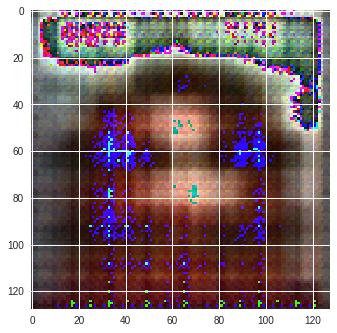

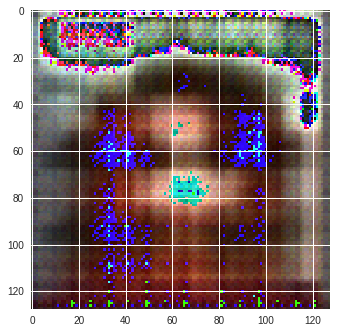

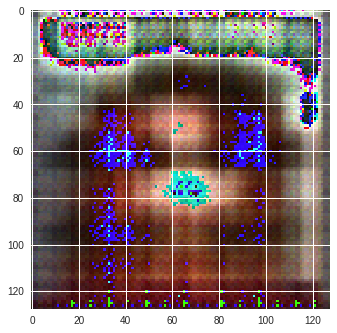

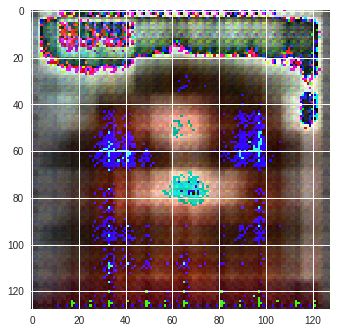

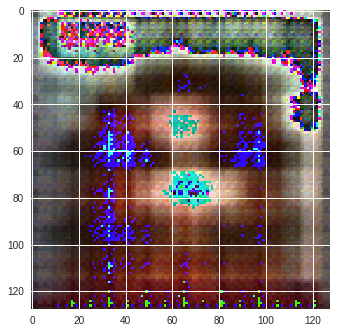

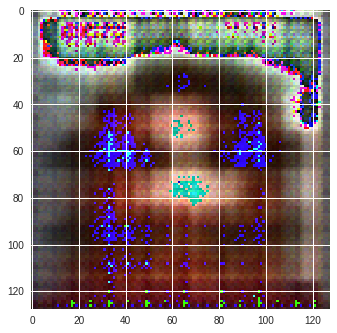

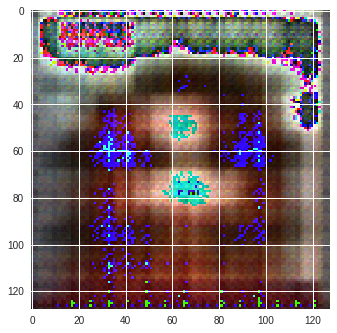

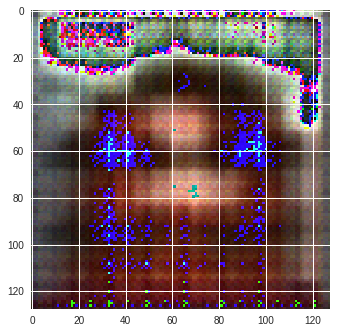

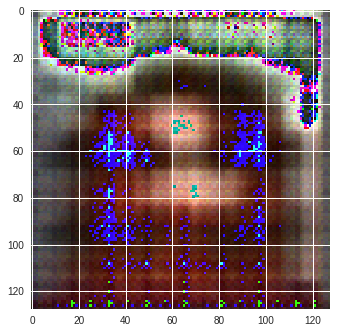

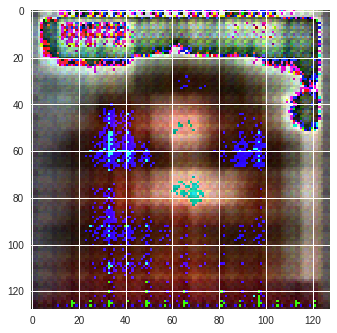

In [18]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
   # display.display(plt.gcf())
   # display.clear_output(wait=True)
    plt.pause(0.001)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

for i in range(10):
  z=torch.from_numpy(np.random.normal(size=100)).float().cuda().view(-1,100)
  #print(z)
  a=generator(z)
  imshow(a)


In [0]:
This was trained for about 6 hours. Not sure why all the pictures are the same, because in between iterations they change wildly but it seems every random z maps to the same image. I would still love to see someone who actually got something working well because I feel like I spent forever doing exactly what the algorithms told me to do and still got garbage. 